In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Equities', 'Foreign') + ['VT', 'ACWI'], 90, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-22 to 2019-07-18 - 77


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

32


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
EWZ,58,0.236327,0.688142,0.331318,15.566648,10.630581
RSX,58,0.155919,0.361941,0.407762,8.033688,5.962674
EWL,58,0.099829,0.280697,0.325957,7.249403,3.113807
EWA,58,0.087580,0.286182,0.276911,5.228165,3.321207
ILF,58,0.084807,0.513039,0.149061,4.283703,10.404973
VIGI,58,0.069847,0.274704,0.223928,4.043477,4.587566
EFAV,58,0.065265,0.198893,0.286243,3.587533,2.819624
EPP,58,0.056079,0.307766,0.155137,3.411274,4.599415
EFG,58,0.048247,0.301103,0.132557,2.619171,4.537548


evicted EWL 0.893 0.113
evicted DEM 0.853 0.457
evicted EPP 0.890 0.295
evicted EWC 0.836 0.106
evicted HEFA 0.838 0.077
evicted EWH 0.820 0.287
evicted VIGI 0.895 0.261
evicted INDA 0.500 0.208
evicted EWA 0.786 0.218
retry backlogs ['EFA', 'SCHF', 'EFG', 'IEV', 'SPDW', 'VEA', 'VT', 'EZU', 'CWI', 'GSIE', 'ACWI', 'IEFA', 'IDEV', 'FEZ', 'DBEF', 'IPAC', 'HEDJ', 'RODM', 'ILF', 'FNDE'] at 0.905/-0.51 - 0.452
evicted FNDE 0.772 0.600
evicted DBEF 0.848 0.090
retry backlogs ['EFA', 'IEV', 'EZU', 'SCHF', 'VEA', 'VT', 'SPDW', 'IEFA', 'ILF', 'CWI', 'RODM', 'IDEV', 'FEZ', 'GSIE', 'IPAC', 'EFG', 'ACWI', 'HEDJ'] at 0.910/-0.52 - 0.452
retry backlogs ['IEV', 'EFA', 'SCHF', 'VEA', 'EZU', 'VT', 'SPDW', 'IEFA', 'ILF', 'RODM', 'IDEV', 'CWI', 'IPAC', 'GSIE', 'FEZ', 'ACWI', 'HEDJ', 'EFG'] at 0.915/-0.53 - 0.452
retry backlogs ['IEV', 'EFA', 'SCHF', 'VEA', 'EZU', 'VT', 'SPDW', 'IEFA', 'ILF', 'RODM', 'IDEV', 'CWI', 'IPAC', 'GSIE', 'FEZ', 'ACWI', 'HEDJ', 'EFG'] at 0.920/-0.54 - 0.452
retry backlogs ['IEV', 

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,58.0,0.160339,0.326995,-0.661043,-0.065641,0.173284,0.414630,0.847420,0.464855,9.680694,4.672799
RSX,58.0,0.155919,0.361941,-0.702154,-0.056382,0.167318,0.442811,0.834201,0.407762,8.033688,5.962674
EWZ,58.0,0.236327,0.688142,-1.679113,-0.174804,0.165433,0.712059,1.449663,0.331318,15.566648,10.630581
EWL,58.0,0.099829,0.280697,-0.471248,-0.098345,0.095524,0.296643,0.749619,0.325957,7.249403,3.113807


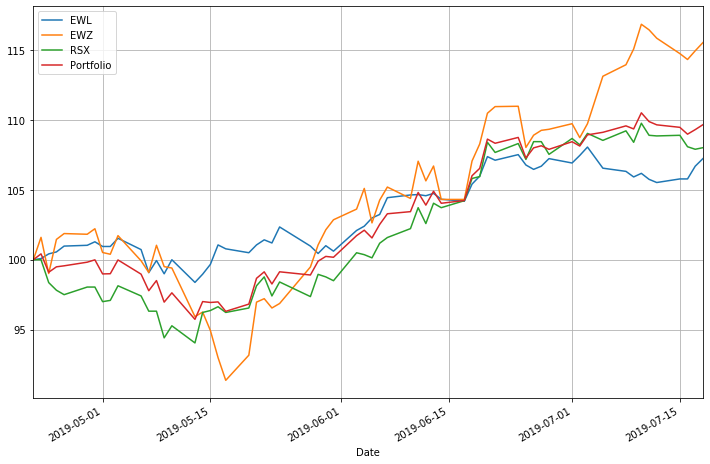

In [6]:
bounds = .12, .16
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1, bounds=bounds)
quote.setup_mask(['RSX', 'EWZ', 'EWL'])
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)